In [58]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = ''
from torch import nn
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from syn_dataset import SynGraphDataset
from spmotif_dataset import *
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_mean_pool, global_max_pool, global_add_pool
from utils import *
from sklearn.model_selection import train_test_split
import shutil
import glob
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import argparse
import pickle
import json
import io
from model import GIN
from train_baseline import test_epoch


# Eval

In [59]:
def get_sparsity(results):
    sparsity_levels = torch.arange(0.8, 0.99, 0.05)
    best_sparsity = max(sparsity_levels, key=lambda sl: np.mean([r['res'][sl.item()]['HFidelity'] for r in results]))
    return (
        np.mean([r['res'][best_sparsity.item()]['HFidelity'] for r in results]),
        np.mean([r['res'][best_sparsity.item()]['Fidelity'] for r in results]), 
        np.mean([r['res'][best_sparsity.item()]['InvFidelity'] for r in results]),
    best_sparsity.item(), )

In [60]:
from IPython.display import HTML
import glob
import numpy as np
import pandas as pd
import pickle
dname = 'MUTAG'
metric = 'Fidelity'
d = {
    'GNNExplainer': [f for f in glob.glob(f'post_hoc/{dname}/*/gnnexplainer.pkl')],
    'IG': [f for f in glob.glob(f'post_hoc/{dname}/*/ig.pkl')],
    'SubGraphX': [f for f in glob.glob(f'post_hoc/{dname}/*/subgraphx.pkl')],
    'GStarX': [f for f in glob.glob(f'post_hoc/{dname}/*/gstarx.pkl')],
    'TELL': [f for f in glob.glob(f'post_hoc/{dname}/*/tell.pkl')],
}

r = {}
for k in d:
    tmps = []
    for f in d[k]:
        # print(f)
        tmp = pickle.load(open(f, 'rb'))
        tmps.append(tmp)
    r[k] =  [
        "$%.1f \\pm %.1f$"%(100*np.mean([np.mean([r['res_topk'][1][metric] for r in tmp]) for tmp in tmps]), 100*np.std([np.mean([r['res_topk'][1][metric] for r in tmp]) for tmp in tmps])),
        "$%.1f \\pm %.1f$"%(100*np.mean([np.mean([r['res_topk'][3][metric] for r in tmp]) for tmp in tmps]), 100*np.std([np.mean([r['res_topk'][3][metric] for r in tmp]) for tmp in tmps])),
        "$%.1f \\pm %.1f$"%(100*np.mean([np.mean([r['res_topk'][5][metric] for r in tmp]) for tmp in tmps]), 100*np.std([np.mean([r['res_topk'][5][metric] for r in tmp]) for tmp in tmps])),
    ]

results_df = pd.DataFrame(r).T
results_df.columns = ['top1', 'top3', 'top5']
results_df

,top1,top3,top5
GNNExplainer,$10.5 \pm 0.0$,$57.9 \pm 0.0$,$47.4 \pm 0.0$
IG,$21.1 \pm 0.0$,$21.1 \pm 0.0$,$42.1 \pm 0.0$
SubGraphX,$31.6 \pm 0.0$,$57.9 \pm 0.0$,$63.2 \pm 0.0$
GStarX,$21.1 \pm 0.0$,$57.9 \pm 0.0$,$63.2 \pm 0.0$
TELL,$47.4 \pm 0.0$,$57.9 \pm 0.0$,$63.2 \pm 0.0$


MUTAG


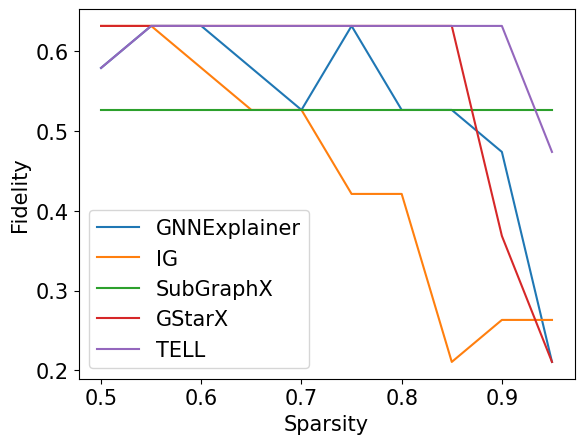

MUTAG


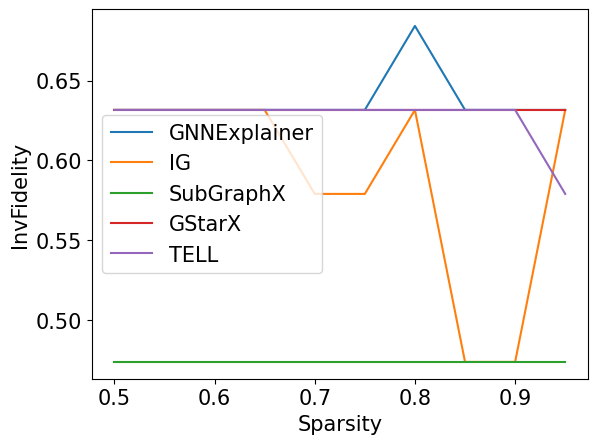

In [61]:
datasets = ['MUTAG']
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
for metric in ['Fidelity', 'InvFidelity']:
    for i, dname in enumerate(datasets):
        d = {
            'GNNExplainer': [f for f in glob.glob(f'post_hoc/{dname}/*/gnnexplainer.pkl')],
            'IG': [f for f in glob.glob(f'post_hoc/{dname}/*/ig.pkl')],
            'SubGraphX': [f for f in glob.glob(f'post_hoc/{dname}/*/subgraphx.pkl')],
            'GStarX': [f for f in glob.glob(f'post_hoc/{dname}/*/gstarx.pkl')],
            'TELL': [f for f in glob.glob(f'post_hoc/{dname}/*/tell.pkl')],
        }
        
        print(dname)
        for k in d:
            tmps = []
            for f in d[k]:
                try:
                    tmp = pickle.load(open(f, 'rb'))
                    tmps.append(tmp)
                except:
                    pass
            if not tmps: continue
            ys = []
            for tmp in tmps:
                sparsity_levels = torch.arange(0.5, 0.99, 0.05)
                y = []
                x = []
                for sl in sparsity_levels:
                    sl = sl.item()
                    m = np.mean([r['res'][sl][metric] for r in tmp])
                    x.append(sl)
                    y.append(m)
                ys.append(y)
        
            y = np.mean(ys, 0)
            yM = np.max(ys,0)
            ym = np.min(ys,0)
            plt.plot(x, y, label=k)
            # plt.fill_between(x, ym, yM, alpha=0.1)
        plt.xlabel('Sparsity')
        plt.ylabel(metric)
        # plt.title(dataset_name)
        plt.legend()
        # plt.show()
        # plt.savefig(f'post_hoc/imgs/{dname}_{metric}.png', dpi=300)
        plt.show()

# Rules

In [62]:
import os
import json
from torch import nn
import torch
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from syn_dataset import SynGraphDataset
from spmotif_dataset import *
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_mean_pool, global_max_pool, global_add_pool
from utils import *
from sklearn.model_selection import train_test_split
import shutil
import glob
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import argparse
import pickle
import json
import io
from model import GIN
from train_baseline import test_epoch
from tell_sigmoid import LogicalLayer
import sys
import pickle
import torch
from torch_geometric.data import Data, Batch
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def get_best_baseline_path(dataset_name):
    l = glob.glob(f'results/{dataset_name}/*/results.json')
    fl = [json.load(open(f)) for f in l]
    df = pd.DataFrame(fl)
    if df.shape[0] == 0: return None
    df['fname'] = l
    df = df.sort_values(by=['val_acc_mean', 'val_acc_std', 'test_acc_std'], ascending=[True,False,False])
    # df = df[df.fname.str.contains('nogumbel=True')]
    print(df)
    fname = df.iloc[-1]['fname']
    fname = fname.replace('/results.json', '')
    return fname


def forward_tell(self):
    def fwd(x, edge_index, batch=None, activations=False, *args, **kwargs):
        if batch is None:
            batch = torch.zeros(x.shape[0]).long().to(x.device)
        xs = []
        for conv in self.convs:
            x = conv(x, edge_index)
            xs.append(x)
            x = self.dropout(x)
    
        x_mean = global_mean_pool(torch.hstack(xs), batch)
        x_max = global_max_pool(torch.hstack(xs), batch)
        x_sum = global_add_pool(torch.hstack(xs), batch)
        x = torch.hstack([x_mean, x_max, x_sum])
        # x = self.dropout(x)
        acts = self.fc.phi_in(x)
        x = self.fc(x)
        if activations:
            return x, acts, xs
        return x
    return fwd


dataset_name = 'MUTAG'
seed = 0

results_path = os.path.join(get_best_baseline_path(dataset_name), str(seed))
data = pickle.load(open(os.path.join(results_path, 'data.pkl'), 'rb'))
args = json.load(open(os.path.join(results_path, 'args.json'), 'r'))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
dataset = get_dataset(dataset_name)
num_classes = dataset.num_classes
num_features = dataset.num_features
num_layers = args['num_layers']
hidden_dim = args['hidden_dim']
model = GIN(num_classes=num_classes, num_features=num_features, num_layers=num_layers, hidden_dim=hidden_dim, dropout=0.1)
model.load_state_dict(torch.load(os.path.join(results_path, 'best.pt'), map_location=device))
model = model.to(device)
train_indices = data['train_indices']
val_indices = data['val_indices']
test_indices = data['test_indices']
train_dataset = dataset[train_indices]
val_dataset = dataset[val_indices]
test_dataset = dataset[test_indices]
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_acc = test_epoch(model, val_loader, device)
test_acc = test_epoch(model, test_loader, device)

model_tell = pickle.load(open(f'post_hoc/{dataset_name}/{seed}/tell_model.pkl', 'rb'))
model_tell.forward = forward_tell(model_tell)

    val_acc_mean  test_acc_mean  val_acc_std  test_acc_std  \
0       0.931579       0.857895     0.065877      0.055755   
10      0.931579       0.800000     0.055755      0.064699   
6       0.936842       0.836842     0.059752      0.083954   
15      0.936842       0.821053     0.059752      0.066574   
14      0.942105       0.810526     0.063012      0.105846   
8       0.942105       0.847368     0.063012      0.083954   
1       0.942105       0.852632     0.063012      0.073601   
7       0.942105       0.878947     0.052338      0.092999   
4       0.942105       0.836842     0.052338      0.080204   
3       0.947368       0.831579     0.065643      0.069293   
9       0.947368       0.821053     0.042974      0.083033   
13      0.947368       0.836842     0.042974      0.063012   
11      0.952632       0.815789     0.067720      0.083218   
5       0.952632       0.826316     0.046084      0.078654   
2       0.952632       0.868421     0.038835      0.071263   
12      

In [63]:
def inverse_sigmoid(x):
    """Computes the inverse of the sigmoid function (logit function)."""
    return torch.log(x / (1 - x))

torch.no_grad()
def find_logic_rules(w, t_in, t_out, activations=None, max_rule_len=10, max_rules=100, min_support=1):
    w = w.clone()
    t_in = t_in.clone()
    t_out = t_out.clone()
    t_out = t_out.item()
    ordering_scores = w
    sorted_idxs = torch.argsort(ordering_scores, 0, descending=True)
    mask = w > 1e-5
    if activations is not None:
        mask = mask & (activations.sum(0) >= min_support)
    total_result = set()

    # Filter and sort indices based on the mask
    idxs_to_visit = sorted_idxs[mask[sorted_idxs]]
    if idxs_to_visit.numel() == 0:
        return total_result

    # Sort weights based on the filtered indices
    sorted_weights = w[idxs_to_visit]
    current_combination = []
    result = set()

    def find_logic_rules_recursive(index, current_sum):
        # Stop if the maximum number of rules has been reached
        if len(result) >= max_rules:
            return

        if len(current_combination) > max_rule_len:
            return

        # Check if the current combination satisfies the condition
        if current_sum >= t_out:
            c = idxs_to_visit[current_combination].cpu().detach().tolist()
            c = tuple(sorted(c))
            result.add(c)
            return

        # Prune if remaining weights can't satisfy t_out
        remaining_max_sum = current_sum + sorted_weights[index:].sum()
        if remaining_max_sum < t_out:
            return

        # Explore further combinations
        for i in range(index, idxs_to_visit.shape[0]):
            # Prune based on activations if provided
            if activations is not None and len(current_combination) > 0 and activations[:, idxs_to_visit[current_combination + [i]]].all(-1).sum().item() < min_support:
                continue

            current_combination.append(i)
            find_logic_rules_recursive(i + 1, current_sum + sorted_weights[i])
            current_combination.pop()

    # Start the recursive process
    find_logic_rules_recursive(0, 0)
    return result


def extract_rules(self, feature=None, activations=None, max_rule_len=float('inf'), max_rules=100, min_support=1, out_threshold=0.5):
    ws = self.weight
    t_in = self.phi_in.t
    t_out = -self.b + inverse_sigmoid(torch.tensor(out_threshold))

    rules = []
    if feature is None:
        features = range(self.out_features)
    else:
        features = [feature]
    for i in features:
        w = ws[i].to('cpu')
        ti = t_in.to('cpu')
        to = t_out[i].to('cpu')
        rules.append(find_logic_rules(w, ti, to, activations, max_rule_len, max_rules, min_support))

    return rules



def get_blues_color(value):
    cmap = plt.get_cmap("Blues")  # Get the Blues colormap
    return cmap(value)  # Return the RGBA color

def plot_activations(batch_ids, batch, attr, soft=False):
    if type(batch_ids) != list:
        batch_ids = [batch_ids]
    if soft: attr = (attr-attr.min() + 1e-6)/(attr.max()-attr.min()+1e-6)
    fig, axs = plt.subplots(1, len(batch_ids), figsize=(16*len(batch_ids), 8))
    if type(axs) != np.ndarray: axs = np.array([axs])
    for i, batch_id in enumerate(batch_ids):
        node_mask = batch.batch == batch_id  # Get nodes where batch == 0
        node_indices = torch.nonzero(node_mask, as_tuple=True)[0]
        
        subgraph_edge_mask = (batch.batch[batch.edge_index[0]] == batch_id) & \
                             (batch.batch[batch.edge_index[1]] == batch_id)
        subgraph_edges = batch.edge_index[:, subgraph_edge_mask]
        
        node_mapping = {old_idx.item(): new_idx for new_idx, old_idx in enumerate(node_indices)}
        remapped_edges = torch.tensor([[node_mapping[e.item()] for e in edge] for edge in subgraph_edges.T])
        
        G = nx.Graph()
        G.add_edges_from(remapped_edges.numpy())
        
        nx.set_node_attributes(G, {v: k for k, v in node_mapping.items()}, "original_id")
        
        node_colors = []
        node_borders = []
        
        for node in G.nodes:
            node_colors.append(get_blues_color(attr[batch.batch==batch_id][node]))  # Fill color
            
        
        pos = nx.kamada_kawai_layout(G) 
        
        nx.draw(
            G, pos,
            node_color=node_colors,
            edgecolors=node_borders,  # Border colors
            node_size=700,
            with_labels=False,
            ax = axs[i]
        )
        
        axs[i].set_title(f"Class = {batch.y[batch_id]}")
    plt.show()



In [64]:
last_layer_rules = extract_rules(model_tell.fc)

In [65]:
model_tell

GIN(
  (convs): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=7, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    ))
    (1): GINConv(nn=Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    ))
    (2): GINConv(nn=Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    ))
    (3): GINConv(nn=Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    ))
    (4): GINConv(nn=Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
   

In [66]:
p1 = []
p2 = []
for batch in test_loader:
    p1_i = model(batch.x.float().to(device), batch.edge_index.to(device), batch.batch.to(device))
    p2_i = model_tell(batch.x.float().to(device), batch.edge_index.to(device), batch.batch.to(device))

    p1.append(p1_i)
    p2.append(p2_i)

In [67]:
(torch.vstack(p1).argmax(-1) == torch.vstack(p2).argmax(-1)).float().mean()

tensor(0.8421, device='cuda:0')

In [68]:
with torch.no_grad():
    activations = None
    for batch in val_loader:
        xs, ys = model_tell.forward_e(batch.x.float().to(device), batch.edge_index.to(device), batch.batch.to(device))
        acts = model_tell.fc.phi_in(xs[-1])>=0.5
        if activations is None:
            activations = acts
        else:
            activations = torch.vstack([activations, acts])

In [69]:
feat_map = []
for readout in ['mean', 'max', 'sum']:
    for l in range(num_layers):
        for d in range(hidden_dim):
            feat_map.append((readout, l, d))


In [70]:
last_layer_rules_renamed = []
for c in range(len(last_layer_rules)):
    s = set()
    for t in last_layer_rules[c]:
        new_t = []
        for i in t:
            if not activations[:,i].all().item() and activations[:,i].any().item():
                new_t.append((i, *feat_map[i]))
        s.add(tuple(new_t))
    last_layer_rules_renamed.append(s)

In [71]:
from torch_geometric.utils import to_networkx, subgraph
from torch_geometric.utils import k_hop_subgraph

def get_subgraph(data, node_mask):
    nodes_to_keep = torch.where(node_mask)[0]
    new_edge_index = subgraph(nodes_to_keep, data.edge_index, relabel_nodes=True)[0]
    new_x = data.x[node_mask]

    G = to_networkx(Data(x=new_x, edge_index=new_edge_index), to_undirected=True)
    return G

def get_subgraphs(data, node_mask):
    G = get_subgraph(data, node_mask)
    node_map = {}
    for i, elem in enumerate(node_mask):
        if elem: node_map[len(node_map)] = i
    # G = nx.DiGraph(G)
    subgraphs = []
    for component in nx.connected_components(G):
        component_mask = torch.zeros_like(node_mask, dtype=torch.bool)
        component_indices = [node_map[i] for i in list(component)]
        component_mask[component_indices] = True
        subgraphs.append((G.subgraph(component), component_mask))
    
    return subgraphs

In [72]:
import tqdm

15


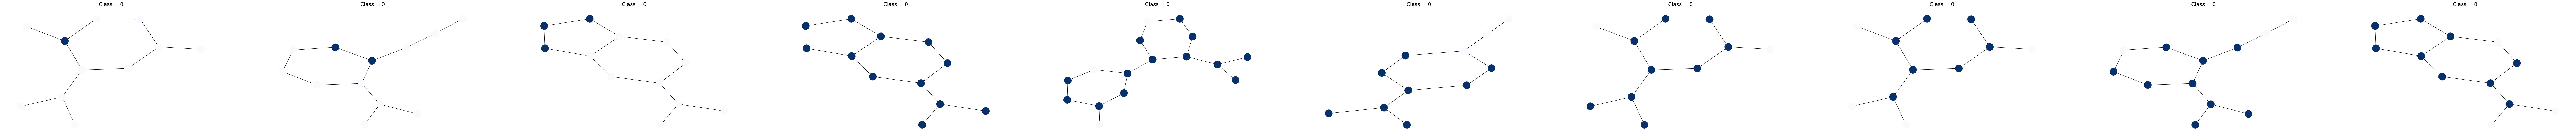

In [73]:
representatives = []
c = 0
for rule in last_layer_rules_renamed[c]:
    # for literal in rule:
    # print(rule)
    for data in test_dataset:
        # try:
            # print('hey')
            batch = Batch.from_data_list([data])
        
            xs, ys = model_tell.forward_e(batch.x.float().to(device), batch.edge_index.to(device), batch.batch.to(device))
            if data.y != c: continue
            acts = model_tell.fc.phi_in(xs[-1])>=0.5
            ll_feats = [literal[0] for literal in rule]
            
            if not acts[:,ll_feats].all(): continue
            node_mask = torch.ones(data.x.shape[0]).bool()
            for literal in rule:
                m = (ys[literal[2]][:,literal[3]].detach().cpu())
                m_=torch.zeros_like(m)
                for i in range(len(m)):
                    if (literal[1] == 'max' and m[i] == m.max()) or (literal[1] != 'max' and  m[i] > 0):
                        # try:
                            subset, _, _, _ = k_hop_subgraph(i, 1, data.edge_index.cpu())
                            m_[subset] += m[i]
                        # except:
                            m_[i] = m[i]
                m_[m_>0] = 1
                m=m_
                if literal[1] == 'max':
                    m = (m == m.max())
                else:
                    m = (m > 0)
                if m.all():continue
                node_mask &= m
            if node_mask.sum().item() == 0: continue
            Gs = get_subgraphs(data, node_mask)
            # print(Gs)
            # Gs = [get_subgraph(data, node_mask)]
            # print('lol')
            for G, G_mask in Gs:
                isomorphic = False
                for i, (G1, _) in enumerate(representatives):
                    if nx.is_isomorphic(G, G1): 
                        isomorphic=True
                        representatives[i][-1].append([batch, G_mask])
                        break
                if not isomorphic:
                    representatives.append([G, [[batch, G_mask]]])
        # except:
        #     pass

representatives.sort(key=lambda x: len(x[1]), reverse=True)
print(len(representatives))
representatives = representatives[:10]



if len(representatives):plot_activations(list(range(len(representatives))), Batch.from_data_list([x[1][0][0] for x in representatives]), torch.cat([x[1][0][1] for x in representatives]).float())

    
